In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


## An Overview of Advanced Lane Finding Pipeline  

**Here are the steps I took to develop advanced lane detection pipeline**  

Below, I have explained the classes I have introduced just to improve logic design, code readability and traceability. 

## 1. Defining `Camera` Class  

`Camera` class implements the methods required to calibrate, undistort, warp, and unwarp an image. These methods are used in the pipeline below to extract the lanes. It also keeps and encapsulates the calibrated paramters. 

- `class Camera`  
  - `calibrate` : To compute the camera calibration matrix and distortion coefficients. it should be called only once. To do so, this function reads all the chessboard images uploaded in the specifed folder and it tries to calibrate based on these pics. 
  - `undistort` : To undistort an image by applying the calibrated parameters.  
  - `calibratePerspectiveTransform` : To calibrate perspective transfrm paramters using the following steps. These params are used for both warp and unwarp functions. 
    * Identify four source points for the perspective transform. In this case, we assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. 

    * Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above. The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.
    
    * Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). When applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.


  - `warp` : To warp an image - to eye-bird view transformation. 
  - `unwarp` : To warp an image - to perspective view transformation. 
  
***

**Note:** Source points are the `x` and `y` pixel values of any four corners on the chessboard. They can be extracted from the corners array output from `cv2.findChessboardCorners()`. So, the destination points are the `x` and `y` pixel values of where we want those four corners to be mapped on in the output image.  


## 2. Defining `ImageColorTransform` Class  

`ImageColorTransform` class implements the methods required to transform an image to a binary image, capturing lanes using different approaches and thresholds. It also introduces some variable to bookkeep Sobel calculated values and lane-fit paramters. This bookkeeping helps to get improved perfrmance by avoding some unnecesary re-calculations. Example of these variables are `sobelX`, `sobelY`, `leftLanePolyFitParams`, and `rightLanePolyFitParams`. The local threshold variables, that are introduced within these methods, are calibrated after several trials on test and challenge videos - although more works need to be done to get better result for '*even-harder*' challenge video.  

- `class ImageColorTransform`  
  - `regionOfInterest` :  
      To extract an image focused on a the front side of the car / camera. This is done by defining a trapezoidal mask applied to the input image. 
  - `sobelAbsoluteFilter`, `sobelMagnitudeFilter`, and `sobelDirectionFilter` methods :  
      These methods are used to calculate Sobel gradient measures in `x` and `y` durections and apply threshods to obtain binary images, filtering out the lanes.  
    
  - `getCombinedFiltersImage` :  
      This function takes an input image and returns a binary image by combining the best approaches to extract lanes. These approaches are combinations of Saturation and Red channels together with the gradients with some ligh-depedent thresholds. It first divides the y-zone into `zoneCount` portions and then each parameter is applied based on the ligh condition of that zone. Here are some of the parameters calibrated based on zonal light conditions: 
    * `sSobelXThresholds` :  Sobel threshold of S-channel in `x` direction  
    * `sSobelYThresholds` :  Sobel threshold of S-channel in `y` direction  
    * `rSobelXThresholds` :  Sobel threshold of Red-channel in `x` direction  
    * `rSobelYThresholds` :  Sobel threshold of Red-channel in `y` direction  
    * `saturationIntensityFactor` : An intensity factor that is multiplied with the average saturation value of each zone to filter out some noises based on lighting conditions 
    * `lightIntensityFactor` : An intensity factor that is multiplied with the average light value of each zone to filter out pixels with less lighting value  
    
    It should be noted that these parameters are calibrated for different lighting conditions. `meanZoneLight < 50`, `meanZoneLight < 100`, `meanZoneLight < 130`, `meanZoneLight < 150`, and `meanZoneLight > 150`. This function returns `combinedBinaryImage` which is obtained by combining different thresholds - ref to the maon body of the function below.  

  - `findLanePixels` :  
    This function takes a binary warped (transformed to bird-eye view) image as input and returns the coordinates of the points that are likely placed at the left and right lanes. It performs a *window-based* search to identify the white points on the lanes. One big difference - or improvement  - done to the counter method implemented as a part of the quiz is as follows: I noticd that the previous implementaion would treat the points that are closer to the camera the same way as the ones that are far from it. This usually creates a problem of confusing the algorithm available sources of noises far from the camera. So I have introduced a weight-based pixel counting to mitigate this situaiton.  
    
  - `mapNewPolynomialToLanes` :  
    This function takes a binary warped (transformed to bird-eye view) image as an input and it performs a while lane search method using a fresh start approach, by searching for windows containing the lanes - as explained above. It returns `yPoints`, `leftLaneFitXs` (parabola fit parameters of the left lane), `rightLaneFitXs` (parabola fit parameters of the right lane), `leftLaneCurveRad` (curvature of the left lane), `rightLaneCurveRad` (curvature of the right lane), and `resultImage` in which the area between the lanes are shaded by green color.  
    
  - `mapPolynomialToLanesBySearch` :  
    This function takes a binary warped (transformed to bird-eye view) image as an input and it performs a while lane search method using search method. Search method works with the previoudly calculated lane fit paramters and finds the new lane parameters using the previous fit parameters. This should improve the performance as compared to the method above, searching for windows in each frame. Like `mapNewPolynomialToLanes` function, it returns `yPoints`, `leftLaneFitXs` (parabola fit parameters of the left lane), `rightLaneFitXs` (parabola fit parameters of the right lane), `leftLaneCurveRad` (curvature of the left lane), `rightLaneCurveRad` (curvature of the right lane), and `resultImage` in which the area between the lanes are shaded by green color. 
    **Note:** If this functin fails to find new lanes, it returns a None value as `fitLaneImage` variable, trigerring the fresh *window-based* search algorithm. 


### Some OpenCV functions used for this project  

- `cv2.inRange()` for color selection  
- `cv2.fillPoly()` for regions selection  
- `cv2.line()` to draw lines on an image given endpoints  
- `cv2.addWeighted()` to coadd / overlay two images  
- `cv2.cvtColor()` to grayscale or change color  
- `cv2.imwrite()` to output images to file  
- `cv2.bitwise_and()` to apply a mask to an image

## 3. Discussions  

### Some Problems Issues Faced: 

- Different illumination / lighting conditions. To overcome this challenge, I had to split the image into miltiple smaller zones and check the average lighting conditions of each zone. The parameters are then calibrated for each lighting conditions.  

- In the original window-based search algorithm suggested by Udacity, I noticed that the start point of left and right lanes are affected by the white points far from the car camera. Ideally this should not cause any issue by nature, but since there are likely some wrong indications or noises where the lanes merge - far from the car camera - that would influence the start point estimation in a negative way. So I had to modify the algorithm by introducing a weight function, penalizing those far points ina linear regressin manner.  

- I have also noticed that there are some discrepancies between images loaded by `matplotlib.image` and the one extracted from video using `fl_image`, making it slightly challenging to debug the code, as I was not able to get identical results while procesing images alone. I have posted the detailed discussion on the issue in StackOverflow portal, hopefully someone could take a look. 
[Click Here](https://stackoverflow.com/questions/56464012/discrepancies-between-images-loaded-by-matplotlib-image-and-the-one-extracted)


### Some Improvement Areas  

- The algorithm should work well to an acceptable extent as far as two lanes are visible at least up to some extent. As shown in *harder-challenge video* once the car approach a sharp turn, suddenly one lane may not be visible. Since I wanted to submit the project at this stage, I had not spent time to account for this situation, i.e. working only with a single lane visible. 

- Light reflection - from back window or side mirror of the front cars for example - could give result it failure of the algorithm to. This can be resolved by better calibration of the already-introducrd parameters, that are set based on diffeernt lighting conditions. This scenario is also observed in *harder-challenge video*. Will work on it to improve the performance after this revision. 

- When the lanes marge far from the camera, it is challenging to distinguish between lanes and light reflections. That would possibly confuse the algorithm too. One potential solution is to incentify the lanes detected closer to the camera. 

- no matter how hard we try to obtain the best performace using Cv only, there are certain situations that pure CV-based algorithms would fail, as discussed in the [link](https://towardsdatascience.com/lane-detection-with-deep-learning-part-1-9e096f3320b7) introduced for example. Deep learning can significantly help close this gap and incease accuracy. 

### Loading required modules 

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import matplotlib
import os

### Define Camera Class

In [2]:
class Camera:
    def __init__(self):
        self.nx = 0
        self.ny = 0
        
        # self.objectPoints = []
        # self.imagePoints = []

        self.imageShape = None

        self.ret = -1.0
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
        self.perspectiveTransformMatrix = None
        self.perspectiveTransformMatrixInv = None
    
    def isCalibrated(self):
        return self.ret >= 0
    
    def calibrate(self, calImageFiles, nx, ny):
        '''
        it calibrates the camera parameters based on the calibration image files (chessboard is recommended)
        '''

        self.nx = nx
        self.ny = ny
        
        self.imageShape = None
        
        objectPoints = []
        imagePoints = []
        
        objGridPoints = np.zeros((nx*ny, 3), dtype=np.float32)
        objGridPoints[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

        for imageIndex, imageFile in enumerate(calImageFiles):
            undistortedImage = cv2.imread(imageFile)
            grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
            patternFound, corners = cv2.findChessboardCorners(grayImage, (nx, ny), None)

            if(patternFound):
                objectPoints.append(objGridPoints)
                imagePoints.append(np.squeeze(corners))

                if(self.imageShape == None):
                    self.imageShape = (undistortedImage.shape[0], undistortedImage.shape[1])
            
            print("Calibration in progress: {0:d} out of {1:d}".format(imageIndex+1, len(calImageFiles)), end="\r")
            
        print("")
        print("Done.")
        
        self.ret, self.mtx, self.dist,  self.rvecs, self.tvecs = cv2.calibrateCamera(objectPoints, imagePoints, 
                                                                                     self.imageShape, None, None)
    
    def undistort(self, image):
        assert self.isCalibrated(), "Calibrate the camera first"
        
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def orderPoints(points):
        # Ordering: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype = "float32")
        
        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = points.sum(axis = 1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]
        
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(points, axis = 1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]
        
        # return the ordered coordinates
        return rect

    def calibratePerspectiveTransform(self, undistortedImage, corners=None, fitToCorners=False, offsetRatioW=0.75, offsetRatioH=0.75):
        
        '''
        Note: If the 'corners' is empty or None, the 'image' must me a chessboard image
        '''
        
        if(corners is None or corners.size == 0):
            cornersFromChessboard = True
            grayImage = cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2GRAY)
            patternFound, corners = cv2.findChessboardCorners(grayImage, (self.nx, self.ny), None)
        else:
            cornersFromChessboard = False
            patternFound = True
        
        if(patternFound):
            if(cornersFromChessboard):
                cv2.drawChessboardCorners(undistortedImage, (self.nx, self.ny), corners, patternFound)
                corners = corners.reshape(-1, 2)
                rect = Camera.orderPoints(corners)
            else:
                rect = np.asarray([corners[0], corners[1], corners[2], corners[3]])
            
            if(fitToCorners):
                (tl, tr, br, bl) = rect
                
                # compute the width of the new image, which will be the 
                # maximum distance between bottom-right and bottom-left
                # x-coordiates or the top-right and top-left x-coordinates
                widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
                widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
                maxWidth = max(int(widthA), int(widthB))

                # compute the height of the new image, which will be the
                # maximum distance between the top-right and bottom-right
                # y-coordinates or the top-left and bottom-left y-coordinates
                heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
                heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
                maxHeight = max(int(heightA), int(heightB))
            else:
                maxWidth = undistortedImage.shape[1]
                maxHeight = undistortedImage.shape[0]

            # now that we have the dimensions of the new image, construct
            # the set of destination points to obtain a "birds eye view",
            # (i.e. top-down view) of the image, again specifying points
            # in the top-left, top-right, bottom-right, and bottom-left
            # order

            offsetW = offsetRatioW * maxWidth
            offsetH = offsetRatioH * maxHeight

            # Ordering: top-left, top-right, bottom-right, bottom-left

            dest = np.array([
                [offsetW, offsetH],
                [maxWidth - 1 - offsetW, offsetH],
                [maxWidth - 1 - offsetW, maxHeight - 1 - offsetH],
                [offsetW, maxHeight - 1 - offsetH]], dtype = "float32")

            self.perspectiveTransformMatrix = cv2.getPerspectiveTransform(rect, dest)
            self.perspectiveTransformMatrixInv = cv2.getPerspectiveTransform(dest, rect)
            warped = cv2.warpPerspective(undistortedImage, self.perspectiveTransformMatrix, (maxWidth, maxHeight))
            
            # print(undistortedImage.shape)
            print("warped image size (width, height):", (maxWidth, maxHeight))
            # print(warped.shape)
        else:
            print("Warning: no pattern was found")
            
            self.perspectiveTransformMatrix = None
            warped = np.copy(undistortedImage)
            
        return warped, self.perspectiveTransformMatrix

    def warp(self, undistortedImage, width, height):
        warped = cv2.warpPerspective(undistortedImage, self.perspectiveTransformMatrix, (width, height))

        return warped

    def unwarp(self, warpedImage, width, height):
        unwarped = cv2.warpPerspective(warpedImage, self.perspectiveTransformMatrixInv, (width, height))

        return unwarped


### Calibrating Camera and Perspective Transform Parameters 

In [3]:
calImagesDir = "camera_cal/"
roadImagesDir = "test_images/"
calImageFiles = glob.glob(calImagesDir + "*.jpg")

assert len(calImageFiles) > 0, "No image file was found for calibration"

nx = 9
ny = 6

camera = Camera()
camera.calibrate(calImageFiles, nx, ny)

# corners are identified based on this image
calibrationImage = mpimg.imread(roadImagesDir + "straight_lines1.jpg")
undistImage = camera.undistort(calibrationImage)

# tl, tr, br, bl
corners = np.array([[600.0, 446.0], [679.0, 446.0], [1040.0, 680.0], [270.0, 680.0]], dtype=np.float32)

topDownImage, perspectiveM = camera.calibratePerspectiveTransform(undistImage, corners=corners, fitToCorners=False, 
                                                                  offsetRatioW=0.3, offsetRatioH=0.0)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(calibrationImage)
#ax1.set_title("Original Image", fontsize=30)
#ax2.imshow(topDownImage)
#ax2.set_title("Undistorted and Warped Image", fontsize=30)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)


Calibration in progress: 20 out of 20
Done.
warped image size (width, height): (1280, 720)


In [18]:
class ImageColorTransform:
    
    def __init__(self):
        self.sobelX = 0.0
        self.sobelY = 0.0
        
        self.baseImage = None
        
        self.leftLanePolyFitParams = []
        self.rightLanePolyFitParams = []
        
        # For video image processing
        self.isFirstFrame = True
        
        #self.ymPerPix = 30.0 / 720 # meters per pixel in y dimension
        #self.xmPerPix = 3.7 / 700 # meters per pixel in x dimension
        
        self.ymPerPix = (10 * 3.048) / 720 # meters per pixel in y dimension
        #self.xmPerPix = 3.7 / (950 - 420) # meters per pixel in x dimension
        self.xmPerPix = 3.7 / (920 - 380) # meters per pixel in x dimension
        
        self.mxmyRatio = self.xmPerPix / self.ymPerPix
        
    def resetState(self, baseImage, kernelSize=3, logResults=False):
        self.baseImage = baseImage
        
        self.sobelX = cv2.Sobel(self.baseImage, cv2.CV_64F, 1, 0, ksize=kernelSize)
        self.sobelY = cv2.Sobel(self.baseImage, cv2.CV_64F, 0, 1, ksize=kernelSize)
        
        self.sobelX[self.sobelX > 500.0] = 500.0
        self.sobelX[self.sobelX < -500.0] = -500.0
        
        self.sobelY[self.sobelY > 500.0] = 500.0
        self.sobelY[self.sobelY < -500.0] = -500.0
        
        self.sobelMagnitude = ((self.sobelX*self.sobelX) + (self.sobelY*self.sobelY)) ** 0.5
        
        if(logResults):
            print("sobelX: mean:{0:2.3f}  ,  min:{1:2.3f}  ,  max:{2:2.3f}".format(np.mean(np.abs(self.sobelX)), 
                                                                                   np.min(self.sobelX), np.max(self.sobelX)))
            print("sobelY: mean:{0:2.3f}  ,  min:{1:2.3f}  ,  max:{2:2.3f}".format(np.mean(np.abs(self.sobelY)), np.min(self.sobelY), 
                                                                                   np.max(self.sobelY)))
        
    def prepareForVideoProcesing(self):
        self.isFirstFrame = True
        
    def regionOfInterest(self, image, fillBlacksWithMean):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """

        #defining a blank mask to start with
        mask = np.zeros_like(image)

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(image.shape) > 2:
            channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        # defining a trapezoid region to mimic perspective impression of the meeting lanes
        x1 = image.shape[1] * (0.02 - 0.04)
        y1 = image.shape[0]

        x2 = image.shape[1] * (0.45 - 0.05)
        y2 = image.shape[0] * 0.62

        x3 = image.shape[1] * (0.55 + 0.05)
        y3 = image.shape[0] * 0.62

        x4 = image.shape[1] * (0.98 + 0.04)
        y4 = image.shape[0]

        vertices = np.array([[(x1, y1), (x2, y2), (x3, y3), (x4, y4)]], dtype=np.int32)
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        maskedImage = cv2.bitwise_and(image, mask)
        
        if (fillBlacksWithMean):
            maskedImage[maskedImage == 0] = int(np.mean(image))
        
        return maskedImage
    
    def getCruvatureParabola(self, aParam, bParam, evalValue):
        '''
        aParam and bParam must be parabola fit parameters estimated based on pixels, not in meter
        evalValue must be in pixel too
        '''
        
        convertedA = aParam*self.mxmyRatio / self.ymPerPix
        convertedB = bParam*self.mxmyRatio
        secondDerivitive = max(2*abs(convertedA), 1e-6)
        firstDerivitive = 2*convertedA*(evalValue*self.ymPerPix) + convertedB
        
        return ((1 + firstDerivitive**2)**1.5) / np.absolute(secondDerivitive)
    
    def sobelAbsoluteFilter(self, orient="x", thresholds=(0.0, 255.0)):
        
        '''
        This function takes an image and returns a binary image based on Sobel thresholds along x or y direction (gradient) 
        '''
        
        # print("filtering out image based on absolute Sobel value thresholds")
        
        if(orient == "x"):
            absSobel = np.abs(self.sobelX)
        elif(orient == "y"):
            absSobel = np.abs(self.sobelY)
        else:
            raise "orient can only be 'x' or'y'"
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaledImage = np.uint8(255*absSobel / np.max(absSobel))
        
        binaryImage = np.zeros_like(scaledImage)
        binaryImage[(scaledImage > thresholds[0]) & (scaledImage < thresholds[1])] = 1
        
        return binaryImage
    
    def sobelMagnitudeFilter(self, thresholds=(0.0, 255.0)):
        
        '''
        This function takes an image and returns a binary image based on magnitude of Sobel values that are within thresholds 
        '''
        
        # print("filtering out image based on magnitude of Sobel values that are within thresholds")

        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaledImage = np.uint8(255*self.sobelMagnitude / np.max(self.sobelMagnitude))

        binaryImage = np.zeros_like(scaledImage)
        binaryImage[(scaledImage > thresholds[0]) & (scaledImage < thresholds[1])] = 1

        return binaryImage

    def sobelDirectionFilter(self, thresholds=(0.0, np.pi/2)):

        '''
        This function takes an image and returns a binary image based on direction of Sobel gradient that are within thresholds 
        '''
        
        # print("filtering out image based on magnitude of direction of Sobel values that are within thresholds")
        
        absSobelX = np.abs(self.sobelX)
        absSobelY = np.abs(self.sobelY)
        gradDir = np.arctan2(absSobelY, absSobelX)
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaledImage = np.uint8(255*self.sobelMagnitude / np.max(self.sobelMagnitude))
        
        binaryImage = np.zeros_like(gradDir)
        binaryImage[(gradDir > thresholds[0]) & (gradDir < thresholds[1])] = 1
        
        # binary_output = np.copy(img) # Remove this line
        return binaryImage

    def getCombinedFiltersImage(self, sampleImage, zoneCount=5, kernelSize=5, \
                                treatUpperHalfAsSky=True, logResults=True):
        '''
        This function takes an image and returns a binary image by combining the best approaches to extract lanes 
        '''
        
        # image was read using mpimg.imread
        #grayImage = cv2.cvtColor(sampleImage, cv2.COLOR_RGB2GRAY)
        hlsImage = cv2.cvtColor(sampleImage, cv2.COLOR_RGB2HLS)
        #hlsImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2HLS)
        
        #grayImage[(grayImage < 50)] = 0

        lChannel = hlsImage[:,:,1]

        sChannel = hlsImage[:,:,2]
        sChannelImage = np.copy(sChannel)
        #sChannelImage = np.zeros_like(sChannel)
        #sChannelImage[(sChannel > 50) & (sChannel <= 150)] = 1

        #sChannelMean = np.mean(sChannel)
        #sChannelMean = np.sum(sChannel) / np.count_nonzero(sChannel)
        
        rChannel = sampleImage[:,:,0]
        rChannelImage = np.copy(rChannel)
        #rChannelImage = np.zeros_like(sChannel)
        #rChannelImage[(sChannel > 50) & (sChannel <= 150)] = 1

        if(treatUpperHalfAsSky):
            halfWidth = lChannel.shape[0] // 2
            widthIncrement = halfWidth // zoneCount
            lChannelZones = [lChannel[halfWidth + widthIncrement*zoneIndex : halfWidth + widthIncrement*(zoneIndex+1), :] \
                             .flatten() for zoneIndex in range(zoneCount)]
            sChannelZones = [sChannel[halfWidth + widthIncrement*zoneIndex : halfWidth + widthIncrement*(zoneIndex+1), :] \
                             .flatten() for zoneIndex in range(zoneCount)]
            rChannelZones = [rChannel[halfWidth + widthIncrement*zoneIndex : halfWidth + widthIncrement*(zoneIndex+1), :] \
                             .flatten() for zoneIndex in range(zoneCount)]
            #zones.append(lChannel[:halfWidth, :].flatten())
        else:
            widthIncrement = lChannel.shape[0] // zoneCount
            lChannelZones = [lChannel[widthIncrement*zoneIndex : widthIncrement*(zoneIndex+1), :].flatten() 
                     for zoneIndex in range(zoneCount)]
            sChannelZones = [sChannel[widthIncrement*zoneIndex : widthIncrement*(zoneIndex+1), :].flatten() 
                     for zoneIndex in range(zoneCount)]
            rChannelZones = [rChannel[widthIncrement*zoneIndex : widthIncrement*(zoneIndex+1), :].flatten() 
                     for zoneIndex in range(zoneCount)]
        
        #meanZoneLights = [np.mean(zone) for zone in zones]
        meanZoneLights = [np.sum(zone) / (np.count_nonzero(zone)+1e-6) for zone in lChannelZones]
        meanZoneSaturations = [np.sum(zone) / (np.count_nonzero(zone)+1e-6) for zone in sChannelZones]
        meanZoneReds = [np.sum(zone) / (np.count_nonzero(zone)+1e-6) for zone in rChannelZones]
        
        combinedBinaryImage = np.zeros_like(lChannel)

        for zoneIndex in range(zoneCount):
            meanZoneLight = meanZoneLights[zoneIndex]
            meanZoneSaturation = meanZoneSaturations[zoneIndex]
            meanZoneRed = meanZoneReds[zoneIndex]
            
            if(treatUpperHalfAsSky):
                fromWidth = halfWidth + widthIncrement*zoneIndex
            else:
                fromWidth = widthIncrement*zoneIndex
            
            toWidth = fromWidth + widthIncrement

            if(logResults):
                print("from {0:d} to {1:d}: meanZoneLight: {2:1.1f}  ,  meanZoneSaturation={3:1.1f}" \
                      .format(fromWidth, toWidth, meanZoneLight, meanZoneSaturation))

            #sChannelImage[(sChannel < meanZoneSaturation) | (lChannel < meanZoneLight)] = meanZoneSaturation
            #rChannelImage[(rChannel < meanZoneRed) | (lChannel < meanZoneLight)] = meanZoneRed
            
            # lower light conditions mean bigger lower bound to detect lanes 
            
            if(meanZoneLight < 50.0):
                sSobelXThresholds = [15.0, 40.0]
                sSobelYThresholds = [15.0, 40.0]
                
                rSobelXThresholds = [15.0, 40.0]
                rSobelYThresholds = [15.0, 40.0]
                
                saturationIntensityFactor = 1.0
                lightIntensityFactor = 1.0
                #sSobelDirectionThresholds = np.array([0.05, 0.20]) * np.pi / 2.0
            elif(meanZoneLight < 100.0):
                sSobelXThresholds = [35.0, 120.0]
                sSobelYThresholds = [35.0, 120.0]
                
                rSobelXThresholds = [35.0, 120.0]
                rSobelYThresholds = [35.0, 120.0]
                
                saturationIntensityFactor = 1.6
                lightIntensityFactor = 1.6
            elif(meanZoneLight < 130.0):
                sSobelXThresholds = [25.0, 80.0]
                sSobelYThresholds = [25.0, 80.0]

                rSobelXThresholds = [25.0, 80.0]
                rSobelYThresholds = [25.0, 80.0]
                
                saturationIntensityFactor = 1.2
                lightIntensityFactor = 1.3
            elif(meanZoneLight < 150.0):
                sSobelXThresholds = [20.0, 100.0]
                sSobelYThresholds = [20.0, 100.0]
                
                rSobelXThresholds = [20.0, 100.0]
                rSobelYThresholds = [20.0, 100.0]
                
                saturationIntensityFactor = 1.4
                lightIntensityFactor = 1.4
            else:
                sSobelXThresholds = [25.0, 100.0]
                sSobelYThresholds = [25.0, 100.0]

                rSobelXThresholds = [25.0, 100.0]
                rSobelYThresholds = [25.0, 100.0]
                
                saturationIntensityFactor = 2.5
                lightIntensityFactor = 2.5
            
            #saturationIntensityFactor = 1.0
            
            self.resetState(baseImage=sChannelImage[fromWidth:toWidth], kernelSize=kernelSize, logResults=logResults)
            sobelAbsoluteXSImage = self.sobelAbsoluteFilter(orient="x", thresholds=sSobelXThresholds)
            sobelAbsoluteYSImage = self.sobelAbsoluteFilter(orient="y", thresholds=sSobelYThresholds)
            
            self.resetState(baseImage=rChannelImage[fromWidth:toWidth], kernelSize=kernelSize, logResults=logResults)
            sobelAbsoluteXRImage = self.sobelAbsoluteFilter(orient="x", thresholds=rSobelXThresholds)
            sobelAbsoluteYRImage = self.sobelAbsoluteFilter(orient="y", thresholds=rSobelYThresholds)
            
            #sobelDirectionSImage = self.sobelDirectionFilter(thresholds=sSobelDirectionThresholds)

            #self.resetState(baseImage=rChannelImage[fromWidth:toWidth], kernelSize=kernelSize)
            #sobelAbsoluteYRImage = self.sobelAbsoluteFilter(orient="y", thresholds=rSobelYThresholds)

            combinedTempImageZone = np.zeros_like(sobelAbsoluteXSImage)
            # combinedBinaryImage[(sobelAbsoluteYRImage == 1) & (sobelAbsoluteYSImage == 1)] = 1
            #combinedTempImageZone[(sobelAbsoluteYRImage == 1) & (sobelAbsoluteYSImage == 1)] = 1
            #combinedTempImageZone[(sobelAbsoluteXSImage == 1) & (sobelDirectionSImage == 1)] = 1
            
            combinedTempImageZone[(sobelAbsoluteXSImage == 1) & (sobelAbsoluteYSImage == 1) |\
                                  (sobelAbsoluteXRImage == 1) & (sobelAbsoluteYRImage == 1)] = 1

            # 1. to remove boundary noise
            combinedTempImageZone[((sChannel[fromWidth:toWidth] < saturationIntensityFactor*meanZoneSaturation) & \
                                   (lChannel[fromWidth:toWidth] < lightIntensityFactor*meanZoneLight) ) | \
                                  ((rChannel[fromWidth:toWidth] < 1.1*meanZoneRed))] = 0
                                  #((rChannel[fromWidth:toWidth] < 1.1*meanZoneRed) & (lChannel[fromWidth:toWidth] < lightIntensityFactor*meanZoneLight))] = 0

            #print(np.where((sChannel[fromWidth:toWidth] > 1000.01*meanZoneSaturation) == True))
            
            #combinedTempImageZone[lChannel[fromWidth:toWidth] < meanZoneLight] = 0.0

            combinedBinaryImage[fromWidth:toWidth] = combinedTempImageZone
        
        return combinedBinaryImage
    
    def findLanePixels_old(self, warpedImage, windowsCount=9, margin=25, minPixelsCount=10):
        '''
        @warpedImage must be a binary warped image, transformed to bird-eye view
        '''
        
        raise Exception("This method is deprecated - old implementation by Udacity")
        
        #thresh = 127
        #warpedImage = cv2.threshold(warpedImage, thresh, 255, cv2.THRESH_BINARY)[1]

        weightArray = np.linspace(0.1, 1.0, warpedImage.shape[0])
        weightedWarpedImage = warpedImage * weightArray[:, np.newaxis]
        
        # Take a histogram of the bottom half of the image
        #histogram = np.sum(warpedImage[int(warpedImage.shape[0]*0.3):,:], axis=0)
        histogram = np.sum(weightedWarpedImage[int(weightedWarpedImage.shape[0]*0.3):,:], axis=0)
        #histogram = np.sum(weightedWarpedImage, axis=0)
        
        # Create an output image to draw on and visualize the result
        #resultImage = np.dstack((warpedImage, warpedImage, warpedImage))
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midPoint = np.int(histogram.shape[0] // 2)
        offset = np.int(histogram.shape[0] // 10)
        #offset = 0
        leftBaseX = np.argmax(histogram[:midPoint - offset])
        rightBaseX = np.argmax(histogram[midPoint + offset:]) + midPoint + offset
        
        #print("leftBaseX", leftBaseX)
        #print("rightBaseX", rightBaseX)

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        #windowsCount = 9
        # Set the width of the windows +/- margin
        #margin = 100 // 4
        # Set minimum number of pixels found to recenter window
        #minPixelsCount = 50 // 4
        
        # Set height of windows - based on windowsCount above and image shape
        windowHeight = np.int(warpedImage.shape[0] // windowsCount)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warpedImage.nonzero()
        nonzeroYIndices = np.array(nonzero[0])
        nonzeroXIndices = np.array(nonzero[1])
        # Current positions to be updated later for each window in windowsCount
        leftCurrentX = leftBaseX
        rightCurrentX = rightBaseX

        nonzeroArray = np.array(nonzero)#.reshape(-1, 2)

        # Create empty lists to receive left and right lane pixel indices
        leftLanePointsIndices = []
        rightLanePointsIndices = []
        
        #lowerBoundYIndex = int(warpedImage.shape[0] * 0.2)
        
        # Step through the windows one by one
        for window in range(windowsCount):
            # Identify window boundaries in x and y (and right and left)
            
            winLowY = warpedImage.shape[0] - (window+1) * windowHeight
            
            #if (winLowY < lowerBoundYIndex):
            #    break
            
            winHighY = warpedImage.shape[0] - window * windowHeight
            leftWinLowX = leftCurrentX - margin
            leftWinHighX = leftCurrentX + margin
            rightWinLowX = rightCurrentX - margin
            rightWinHighX = rightCurrentX + margin

            # Draw the windows on the visualization image
            #cv2.rectangle(resultImage, (leftWinLowX, winLowY), (leftWinHighX, winHighY), (0,255,0), 2)
            #cv2.rectangle(resultImage, (rightWinLowX, winLowY), (rightWinHighX, winHighY), (0,255,0), 2)
            
            # this variable is introduced for better performance 
            withinYBandsIndices = (nonzeroYIndices >= winLowY) & (nonzeroYIndices < winHighY)
            
            # Identify the nonzero pixels in x and y within the window #

            leftWinLanePointsIndices = (withinYBandsIndices & 
                                        (nonzeroXIndices >= leftWinLowX) &  (nonzeroXIndices < leftWinHighX)).nonzero()[0]
            rightWinLanePointsIndices = (withinYBandsIndices & 
                                         (nonzeroXIndices >= rightWinLowX) &  (nonzeroXIndices < rightWinHighX)).nonzero()[0]
            
            # Append these indices to the lists
            leftLanePointsIndices.append(leftWinLanePointsIndices)
            rightLanePointsIndices.append(rightWinLanePointsIndices)

            # If you found > minPixelsCount pixels, recenter next window on their mean position
            if (len(leftWinLanePointsIndices) > minPixelsCount):
                leftCurrentX = np.int(np.mean(nonzeroXIndices[leftWinLanePointsIndices]))
            if (len(rightWinLanePointsIndices) > minPixelsCount):
                rightCurrentX = np.int(np.mean(nonzeroXIndices[rightWinLanePointsIndices]))
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            leftLanePointsIndices = np.concatenate(leftLanePointsIndices)
            rightLanePointsIndices = np.concatenate(rightLanePointsIndices)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
        
        # Extract left and right line pixel positions
        leftLanePointsXIndices = nonzeroXIndices[leftLanePointsIndices]
        leftLanePointsYIndices = nonzeroYIndices[leftLanePointsIndices]
        rightLanePointsXIndices = nonzeroXIndices[rightLanePointsIndices]
        rightLanePointsYIndices = nonzeroYIndices[rightLanePointsIndices]
        
        return leftLanePointsXIndices, leftLanePointsYIndices, \
            rightLanePointsXIndices, rightLanePointsYIndices #, resultImage

    def findLanePixels(self, warpedImage, windowsCount=9, margin=25, minPixelsCount=10):
        '''
        @warpedImage must be a binary warped image, transformed to bird-eye view
        '''
        
        #thresh = 127
        #warpedImage = cv2.threshold(warpedImage, thresh, 255, cv2.THRESH_BINARY)[1]

        weightArray = np.linspace(0.1, 1.0, warpedImage.shape[0])
        weightedWarpedImage = warpedImage * weightArray[:, np.newaxis]
        
        # Take a histogram of the bottom half of the image
        #histogram = np.sum(warpedImage[int(warpedImage.shape[0]*0.3):,:], axis=0)
        histogram = np.sum(weightedWarpedImage[int(weightedWarpedImage.shape[0]*0.3):,:], axis=0)
        #histogram = np.sum(weightedWarpedImage, axis=0)
        
        # Create an output image to draw on and visualize the result
        #resultImage = np.dstack((warpedImage, warpedImage, warpedImage))
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midPoint = np.int(histogram.shape[0] // 2)
        offset = np.int(histogram.shape[0] // 10)
        #offset = 0
        leftBaseX = np.argmax(histogram[:midPoint - offset])
        rightBaseX = np.argmax(histogram[midPoint + offset:]) + midPoint + offset
        
        #print("leftBaseX", leftBaseX)
        #print("rightBaseX", rightBaseX)

        # Set height of windows - based on windowsCount above and image shape
        windowHeight = np.int(warpedImage.shape[0] // windowsCount)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warpedImage.nonzero()
        nonzeroYIndices = np.array(nonzero[0])
        nonzeroXIndices = np.array(nonzero[1])
        # Current positions to be updated later for each window in windowsCount
        leftCurrentX = leftBaseX
        rightCurrentX = rightBaseX

        nonzeroArray = np.array(nonzero)#.reshape(-1, 2)

        # Create empty lists to receive left and right lane pixel indices
        #leftLanePointsIndices = []
        #rightLanePointsIndices = []
        
        leftLanePointsXIndices = []
        leftLanePointsYIndices = []

        rightLanePointsXIndices = []
        rightLanePointsYIndices = []
        
        #lowerBoundYIndex = int(warpedImage.shape[0] * 0.2)
        
        # Step through the windows one by one
        for window in range(windowsCount):
            # Identify window boundaries in x and y (and right and left)
            
            winLowY = warpedImage.shape[0] - (window+1) * windowHeight
            
            winHighY = warpedImage.shape[0] - window * windowHeight
            leftWinLowX = leftCurrentX - margin
            leftWinHighX = leftCurrentX + margin
            rightWinLowX = rightCurrentX - margin
            rightWinHighX = rightCurrentX + margin

            # Draw the windows on the visualization image
            #cv2.rectangle(resultImage, (leftWinLowX, winLowY), (leftWinHighX, winHighY), (0,255,0), 2)
            #cv2.rectangle(resultImage, (rightWinLowX, winLowY), (rightWinHighX, winHighY), (0,255,0), 2)
            
            # this variable is introduced for better performance 
            withinYBandsIndices = (nonzeroYIndices >= winLowY) & (nonzeroYIndices < winHighY)
            
            # Identify the nonzero pixels in x and y within the window #

            leftWinLanePointsIndices = (withinYBandsIndices & 
                                        (nonzeroXIndices >= leftWinLowX) &  (nonzeroXIndices < leftWinHighX)).nonzero()[0]
            rightWinLanePointsIndices = (withinYBandsIndices & 
                                         (nonzeroXIndices >= rightWinLowX) &  (nonzeroXIndices < rightWinHighX)).nonzero()[0]
            
            # Append these indices to the lists
            #leftLanePointsIndices.append(leftWinLanePointsIndices)
            #rightLanePointsIndices.append(rightWinLanePointsIndices)

            # If you found > minPixelsCount pixels, recenter next window on their mean position
            if (len(leftWinLanePointsIndices) > minPixelsCount):
                leftCurrentX = np.int(np.mean(nonzeroXIndices[leftWinLanePointsIndices]))
                leftCurrentY = np.int(np.mean(nonzeroYIndices[leftWinLanePointsIndices]))
                
                leftLanePointsXIndices.append(leftCurrentX)
                leftLanePointsYIndices.append(leftCurrentY)
                
            if (len(rightWinLanePointsIndices) > minPixelsCount):
                rightCurrentX = np.int(np.mean(nonzeroXIndices[rightWinLanePointsIndices]))
                rightCurrentY = np.int(np.mean(nonzeroYIndices[rightWinLanePointsIndices]))
                
                rightLanePointsXIndices.append(rightCurrentX)
                rightLanePointsYIndices.append(rightCurrentY)
            
        #print("leftLanePointsXIndices:", leftLanePointsXIndices)
        #print("leftLanePointsYIndices:", leftLanePointsYIndices)
        
        #print("rightLanePointsXIndices:", rightLanePointsXIndices)
        #print("rightLanePointsYIndices:", rightLanePointsYIndices)
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            leftLanePointsXIndices = np.asarray(leftLanePointsXIndices)
            leftLanePointsYIndices = np.asarray(leftLanePointsYIndices)

            rightLanePointsXIndices = np.asarray(rightLanePointsXIndices)
            rightLanePointsYIndices = np.asarray(rightLanePointsYIndices)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            print("Warning: np.concatenate failed in method findLanePixels")
            
            pass
        
        return leftLanePointsXIndices, leftLanePointsYIndices, \
            rightLanePointsXIndices, rightLanePointsYIndices #, resultImage

    def mapNewPolynomialToLanes(self, warpedImage, windowsCount=9, margin=50, minPixelsCount=10):
        '''
        @warpedImage must be a binary warped image, transformed to bird-eye view
        '''
        
        # Find our lane pixels first
        leftLanePointsXIndices, leftLanePointsYIndices, \
            rightLanePointsXIndices, rightLanePointsYIndices = \
            self.findLanePixels(warpedImage, windowsCount, margin, minPixelsCount)
        
        #lowerBoundYIndex = int(0.1 * warpedImage.shape[0])
        
        #leftLanePointsXIndices = leftLanePointsXIndices[leftLanePointsYIndices > lowerBoundYIndex]
        #leftLanePointsYIndices = leftLanePointsYIndices[leftLanePointsYIndices > lowerBoundYIndex]
        
        #rightLanePointsXIndices = rightLanePointsXIndices[rightLanePointsYIndices > lowerBoundYIndex]
        #rightLanePointsYIndices = rightLanePointsYIndices[rightLanePointsYIndices > lowerBoundYIndex]
        
        # Generate x and y values for plotting
        yPoints = np.linspace(0, warpedImage.shape[0]-1, warpedImage.shape[0])
        
        try:
            # Fit a second order polynomial to each using `np.polyfit`
            self.leftLanePolyFitParams = np.polyfit(leftLanePointsYIndices, leftLanePointsXIndices, 2)
            
            leftLaneFitXs = self.leftLanePolyFitParams[0]*yPoints**2 + self.leftLanePolyFitParams[1]*yPoints + \
                self.leftLanePolyFitParams[2]
            
            # Calculates the curvature of polynomial functions in meters.

            # Define y-value where we want radius of curvature
            # We'll choose the maximum y-value, corresponding to the bottom of the image
            yEval = np.max(yPoints)
            
            # converted in meter
            leftLaneCurveRad = self.getCruvatureParabola(self.leftLanePolyFitParams[0], self.leftLanePolyFitParams[1], yEval)
            
            # Calculation of R_curve (radius of curvature)
            #leftLaneCurveRad = ((1 + (2*self.leftLanePolyFitParams[0]*yEval + self.leftLanePolyFitParams[1])**2 * self.dydxRatio**2)**1.5) \
            #    / np.absolute(2*self.leftLanePolyFitParams[0] * self.dydxRatio / self.xmPerPix)
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            #print("The function failed to fit a left line!")
            
            leftLaneFitXs = 1.0*yPoints**2 + 1.0*yPoints
            leftLaneCurveRad = 1e6
        
        try:
            # Fit a second order polynomial to each using `np.polyfit`
            self.rightLanePolyFitParams = np.polyfit(rightLanePointsYIndices, rightLanePointsXIndices, 2)
            
            rightLaneFitXs = self.rightLanePolyFitParams[0]*yPoints**2 + self.rightLanePolyFitParams[1]*yPoints + \
                self.rightLanePolyFitParams[2]
            
            # Calculates the curvature of polynomial functions in meters.

            # Define y-value where we want radius of curvature
            # We'll choose the maximum y-value, corresponding to the bottom of the image
            yEval = np.max(yPoints)

            # converted in meter
            rightLaneCurveRad = self.getCruvatureParabola(self.rightLanePolyFitParams[0], self.rightLanePolyFitParams[1], yEval)

            # Calculation of R_curve (radius of curvature)
            #rightLaneCurveRad = ((1 + (2*self.rightLanePolyFitParams[0]*yEval + self.rightLanePolyFitParams[1])**2 * self.dydxRatio**2)**1.5) / \
            #    np.absolute(2*self.rightLanePolyFitParams[0] * self.dydxRatio/self.xmPerPix)
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print("The function failed to fit a right line!")
            
            rightLaneFitXs = 1.0*yPoints**2 + 1.0*yPoints
            rightLaneCurveRad = 1e6
        
        xLeft = leftLaneFitXs[-1]
        xRight = rightLaneFitXs[-1]
        
        carCenterOffset = self.xmPerPix * ((xLeft + xRight) - warpedImage.shape[1]) / 2.0
        
        ## Visualization ##
        # Colors in the left and right lane regions
        #resultImage[leftLanePointsYIndices, leftLanePointsXIndices] = [255, 0, 0]
        #resultImage[rightLanePointsYIndices, rightLanePointsXIndices] = [0, 0, 255]
        
        #resultImage = np.dstack((np.zeros_like(warpedImage, dtype=np.int8), np.zeros_like(warpedImage, dtype=np.int8), np.zeros_like(warpedImage, dtype=np.int8)))
        resultImage = np.zeros_like(warpedImage)
        leftLanePoints = np.array([np.transpose(np.vstack([leftLaneFitXs, yPoints]))])
        rightLanePoints = np.array([np.flipud(np.transpose(np.vstack([rightLaneFitXs, yPoints])))])
        laneLineBoundaryPoints = np.hstack((leftLanePoints, rightLanePoints))
        
        cv2.fillPoly(resultImage, np.int_([laneLineBoundaryPoints]), 255)
        
        # cv2.polylines()
        
        #axis.plot(leftLaneFitPoints, yPoints, color="yellow", linewidth=10)
        #axis.plot(rightLaneFitPoints, yPoints, color="yellow", linewidth=10)
        
        # Plots the left and right polynomials on the lane lines
        #plt.plot(leftLaneFitXs, yPoints, color="yellow")
        #plt.plot(rightLaneFitXs, yPoints, color="yellow")

        return yPoints, leftLaneFitXs, rightLaneFitXs, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, resultImage

    def fitPolynomialToLanes(self, imageShape, leftLaneXs, leftLaneYs, rightLaneXs, rightLaneYs):
        self.leftLanePolyFitParams = np.polyfit(leftLaneYs, leftLaneXs, 2.0)
        self.rightLanePolyFitParams = np.polyfit(rightLaneYs, rightLaneXs, 2.0)
        
        # Generate x and y values for plotting
        yPoints = np.linspace(0, imageShape[0]-1, imageShape[0])
        
        leftLaneFitXs = self.leftLanePolyFitParams[0]*yPoints**2 + self.leftLanePolyFitParams[1]*yPoints + \
            self.leftLanePolyFitParams[2]
        rightLaneFitXs = self.rightLanePolyFitParams[0]*yPoints**2 + self.rightLanePolyFitParams[1]*yPoints + \
            self.rightLanePolyFitParams[2]

        return yPoints, leftLaneFitXs, rightLaneFitXs

    #def mapPolynomialToLanesBySearch(self, warpedImage, margin=50, getSuperimposedImage=False, originalImage=None):
    def mapPolynomialToLanesBySearch(self, warpedImage, margin=50, shadeBetweenLanes=True):
        '''
        @warpedImage must be a binary warped image, transformed to bird-eye view
        '''
        
        # Grab activated pixels
        nonzero = warpedImage.nonzero()
        nonzeroYIndices = np.array(nonzero[0])
        nonzeroXIndices = np.array(nonzero[1])

        # calculated here once for better performance, avoid double calculating
        currentLeftLaneFitXs = self.leftLanePolyFitParams[0]*(nonzeroYIndices**2) + self.leftLanePolyFitParams[1]*nonzeroYIndices + \
            self.leftLanePolyFitParams[2]
        currentRightLaneFitXs = self.rightLanePolyFitParams[0]*(nonzeroYIndices**2) + self.rightLanePolyFitParams[1]*nonzeroYIndices + \
            self.rightLanePolyFitParams[2]
        
        # it is called 'locators' as the result is an arry with True / False values, locating where to look for indices
        leftLaneIndexLocators = ((nonzeroXIndices > (currentLeftLaneFitXs - margin)) & (nonzeroXIndices < (currentLeftLaneFitXs + margin)))
        rightLaneIndexLocators = ((nonzeroXIndices > (currentRightLaneFitXs - margin)) & (nonzeroXIndices < (currentRightLaneFitXs + margin)))
        
        if(leftLaneIndexLocators.size == 0 or rightLaneIndexLocators.size == 0):
            return np.array([]), np.array([]), np.array([]), 0.0, 0.0, np.array([])

        # Extract left and right line pixel positions
        leftLanePointsXIndices = nonzeroXIndices[leftLaneIndexLocators]
        leftLanePointsYIndices = nonzeroYIndices[leftLaneIndexLocators]
        rightLanePointsXIndices = nonzeroXIndices[rightLaneIndexLocators]
        rightLanePointsYIndices = nonzeroYIndices[rightLaneIndexLocators]

        try:
            # Fit new polynomials
            yPoints, leftLaneFitXs, rightLaneFitXs = \
                self.fitPolynomialToLanes(warpedImage.shape, leftLanePointsXIndices, leftLanePointsYIndices, \
                                          rightLanePointsXIndices, rightLanePointsYIndices)
        except:
            return np.array([]), np.array([]), np.array([]), 0.0, 0.0, 0.0, np.array([])

        # Calculates the curvature of polynomial functions in meters.

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        yEval = np.max(yPoints)
        
        distance = (rightLaneFitXs[0]*yEval**2 + rightLaneFitXs[1]*yEval + rightLaneFitXs[2]) - \
            (leftLaneFitXs[0]*yEval**2 + leftLaneFitXs[1]*yEval + leftLaneFitXs[2])
        
        if(distance < 0.6 * warpedImage.shape[1]):
            return np.array([]), np.array([]), np.array([]), 0.0, 0.0, 0.0, np.array([])

        # Calculation of R_curve (radius of curvature)
        #leftLaneCurveRad = ((1 + (2*self.leftLanePolyFitParams[0]*yEval + self.leftLanePolyFitParams[1])**2 * self.dydxRatio**2)**1.5) / \
        #    np.absolute(2*self.leftLanePolyFitParams[0] * self.dydxRatio/self.xmPerPix)

        # converted in meter
        leftLaneCurveRad = self.getCruvatureParabola(self.leftLanePolyFitParams[0], self.leftLanePolyFitParams[1], yEval)
        
        #rightLaneCurveRad = ((1 + (2*self.rightLanePolyFitParams[0]*yEval + self.rightLanePolyFitParams[1])**2 * self.dydxRatio)**1.5) / \
        #    np.absolute(2*self.rightLanePolyFitParams[0] * self.dydxRatio/self.xmPerPix)
        
        # converted in meter
        rightLaneCurveRad = self.getCruvatureParabola(self.rightLanePolyFitParams[0], self.rightLanePolyFitParams[1], yEval)

        resultImage = np.zeros_like(warpedImage)
        
        if(shadeBetweenLanes):
            # Shade the space between the lanes
            leftLanePoints = np.array([np.transpose(np.vstack([leftLaneFitXs, yPoints]))])
            rightLanePoints = np.array([np.flipud(np.transpose(np.vstack([rightLaneFitXs, yPoints])))])
            laneLineBoundaryPoints = np.hstack((leftLanePoints, rightLanePoints))
            cv2.fillPoly(resultImage, np.int_([laneLineBoundaryPoints]), 255)
        else:
            # Create an image to draw on and an image to show the selection window
            #tempImage = np.dstack((warpedImage, warpedImage, warpedImage))*255
            #windowImage = np.zeros_like(tempImage)
            # Color in left and right line pixels
            tempImage[leftLanePointsYIndices, leftLanePointsXIndices] = [255, 0, 0]
            tempImage[rightLanePointsYIndices, rightLanePointsXIndices] = [0, 0, 255]

            ## visualization steps ##
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            leftLineWindow1 = np.array([np.transpose(np.vstack([leftLaneFitXs - margin, yPoints]))])
            leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftLaneFitXs + margin, yPoints])))])
            leftLineWinPoints = np.hstack((leftLineWindow1, leftLineWindow2))

            rightLineWindow1 = np.array([np.transpose(np.vstack([rightLaneFitXs - margin, yPoints]))])
            rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightLaneFitXs + margin, yPoints])))])
            rightLineWinPoints = np.hstack((rightLineWindow1, rightLineWindow2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(windowImage, np.int_([leftLineWinPoints]), (0,255, 0))
            cv2.fillPoly(windowImage, np.int_([rightLineWinPoints]), (0,255, 0))
            resultImage = cv2.addWeighted(tempImage, 1, windowImage, 0.3, 0)
        
        # Plot the polynomial lines onto the image
        #plt.plot(leftLaneFitXs, yPoints, color="yellow")
        #plt.plot(rightLaneFitXs, yPoints, color="yellow")
        ## End visualization steps ##

        xLeft = leftLaneFitXs[-1]
        xRight = rightLaneFitXs[-1]
        
        carCenterOffset = self.xmPerPix * ((xLeft + xRight) - warpedImage.shape[1]) / 2.0
        
        return yPoints, leftLaneFitXs, rightLaneFitXs, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, resultImage
    
    def superimposeImageWithLanes(self, originalImage, yPoints, leftLaneFitXs, rightLaneFitXs):
        laneLineBoundaryImage = np.zeros_like(originalImage)

        leftLanePoints = np.array([np.transpose(np.vstack([leftLaneFitXs, yPoints]))])
        rightLanePoints = np.array([np.flipud(np.transpose(np.vstack([rightLaneFitXs, yPoints])))])

        laneLineBoundaryPoints = np.hstack((leftLanePoints, rightLanePoints))

        cv2.fillPoly(laneLineBoundaryImage, np.int_([laneLineBoundaryPoints]), (0,255, 0))
        superImposedImage = cv2.addWeighted(originalImage, 1, laneLineBoundaryImage, 0.3, 0)

        #cv2.fillPoly(superImposedImage, np.int_([laneLineBoundaryPoints]), (0, 255, 0))
        #cv2.fillPoly(superImposedImage, np.int_([rightLaneFitXs]), (0, 255, 0))
        
        return superImposedImage
        

In [19]:
imageColorTransform = ImageColorTransform()

### Testing Extracted Lanes

- **Testing Warping Images**
- **Calibrating Thresholds and some other few Parameters to Filter out the Lanes Under Different Lighting Conditions**
- **Testing Lane Filtering Thresholds on the Original and Warped Images**

from 360 to 420: meanZoneLight: 0.0  ,  meanZoneSaturation=0.0
sobelX: mean:0.000  ,  min:0.000  ,  max:0.000
sobelY: mean:0.000  ,  min:0.000  ,  max:0.000
sobelX: mean:0.000  ,  min:0.000  ,  max:0.000
sobelY: mean:0.000  ,  min:0.000  ,  max:0.000
from 420 to 480: meanZoneLight: 84.3  ,  meanZoneSaturation=21.0
sobelX: mean:1.713  ,  min:-259.000  ,  max:274.000
sobelY: mean:3.620  ,  min:-353.000  ,  max:359.000
sobelX: mean:2.363  ,  min:-397.000  ,  max:484.000
sobelY: mean:6.212  ,  min:-500.000  ,  max:500.000
from 480 to 540: meanZoneLight: 88.4  ,  meanZoneSaturation=19.7
sobelX: mean:4.297  ,  min:-410.000  ,  max:445.000
sobelY: mean:5.865  ,  min:-500.000  ,  max:500.000
sobelX: mean:5.272  ,  min:-426.000  ,  max:386.000
sobelY: mean:7.847  ,  min:-500.000  ,  max:500.000
from 540 to 600: meanZoneLight: 87.3  ,  meanZoneSaturation=22.6
sobelX: mean:6.817  ,  min:-500.000  ,  max:500.000
sobelY: mean:8.976  ,  min:-500.000  ,  max:500.000
sobelX: mean:7.509  ,  min:-384.00

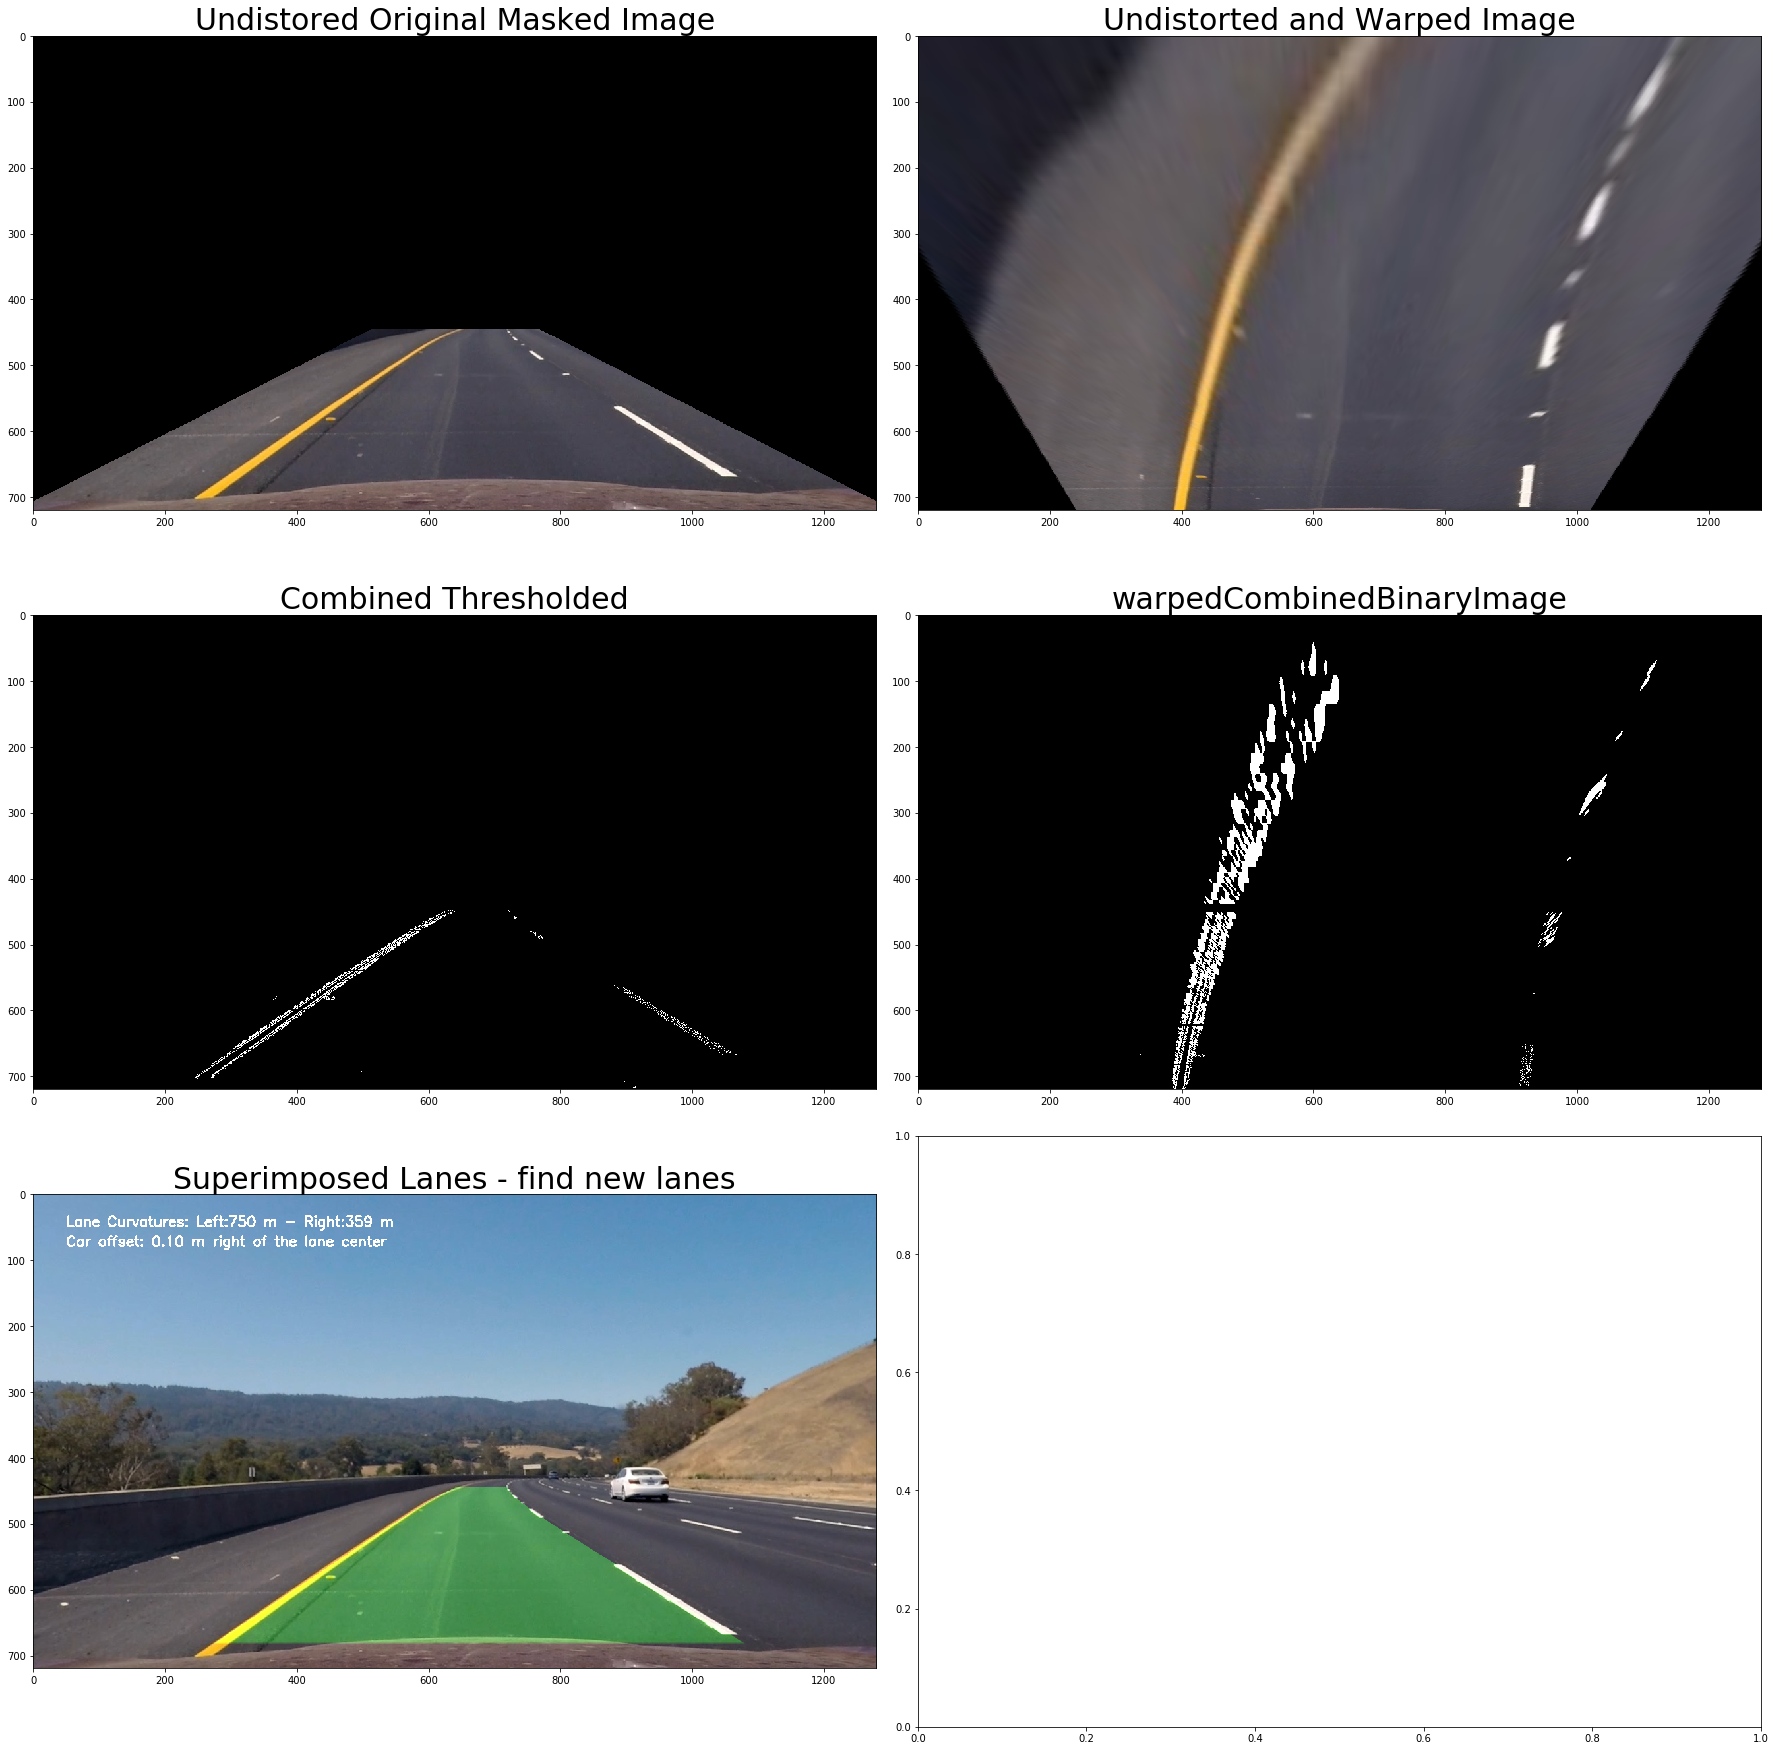

In [16]:
# roadImagesDir = "test_images/"

# sampleImage = cv2.imread(calImageFiles[15])

#sampleImage = mpimg.imread(roadImagesDir + "straight_lines1.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "straight_lines2.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "test1.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "test2.jpg")
sampleImage = mpimg.imread(roadImagesDir + "test3.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "test4.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "test5.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "test6.jpg")

#sampleImage = mpimg.imread(roadImagesDir + "challenge_video-test-01.jpg")
#sampleImage = mpimg.imread(roadImagesDir + "sample-01.jpg")

#sampleImage = mpimg.imread(roadImagesDir + "challenge_video-test-01.jpg")

undistImage = camera.undistort(sampleImage)
maskedImage = imageColorTransform.regionOfInterest(undistImage, fillBlacksWithMean=False)

topDownImage = camera.warp(maskedImage, sampleImage.shape[1], sampleImage.shape[0])

# unwarped image- perspective
combinedBinaryImage = imageColorTransform.getCombinedFiltersImage(maskedImage, zoneCount=6, kernelSize=3, \
                                                                  treatUpperHalfAsSky=True, logResults=True)

warpedCombinedBinaryImage = camera.warp(combinedBinaryImage, combinedBinaryImage.shape[1], combinedBinaryImage.shape[0])

yPoints, leftLaneFitPoints, rightLaneFitPoints, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, fitLaneImage = \
    imageColorTransform.mapNewPolynomialToLanes(warpedCombinedBinaryImage, windowsCount=9, margin=100, minPixelsCount=10)

unwarpedFitLaneImage = camera.unwarp(fitLaneImage, fitLaneImage.shape[1], fitLaneImage.shape[0])
tempLaneImage = np.dstack((np.zeros_like(unwarpedFitLaneImage), unwarpedFitLaneImage, np.zeros_like(unwarpedFitLaneImage)))
superimposedImage = cv2.addWeighted(undistImage, 1, tempLaneImage, 0.3, 0)

leftLaneCurveRadText = "{0:1.0f}".format(leftLaneCurveRad) if(leftLaneCurveRad < 5000.0) else " > 10,000"
rightLaneCurveRadText = "{0:1.0f}".format(rightLaneCurveRad) if(rightLaneCurveRad < 5000.0) else " > 10,000"
text = "Lane Curvatures: Left:{0:s} m - Right:{1:s} m".format(leftLaneCurveRadText, rightLaneCurveRadText)
cv2.putText(superimposedImage, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2, color=(255, 255, 255))

if (carCenterOffset > 0):
    text = "Car offset: {0:1.2f} m right of the lane center".format(carCenterOffset)
else:
    text = "Car offset: {0:1.2f} m left of the lane center".format(carCenterOffset)
    
cv2.putText(superimposedImage, text, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2, color=(255, 255, 255))

print(text)

# Plot the result
f, axes = plt.subplots(3, 2, figsize=(24, 9*3))

axis = axes[0, 0]
axis.imshow(maskedImage)
axis.set_title("Undistored Original Masked Image", fontsize=30)

axis = axes[0, 1]
axis.imshow(topDownImage, cmap="gray")
axis.set_title("Undistorted and Warped Image", fontsize=30)

axis = axes[1, 0]
axis.imshow(combinedBinaryImage, cmap="gray")
axis.set_title("Combined Thresholded", fontsize=30)

axis = axes[1, 1]
axis.imshow(warpedCombinedBinaryImage, cmap="gray")
axis.set_title("warpedCombinedBinaryImage", fontsize=30)

axis = axes[2, 0]
axis.imshow(superimposedImage)
axis.set_title("Superimposed Lanes - find new lanes", fontsize=30)

f.tight_layout()

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

### Defining extractLane Method Based on the Pipeline Tested Above

### Note  
- The instances of `camera` and `imageColorTransform` must be initialized prior to this function 
- `camera` must already be calibrated 

In [20]:
def extractLanes(sampleImage):
    undistImage = camera.undistort(sampleImage)
    maskedImage = imageColorTransform.regionOfInterest(undistImage, fillBlacksWithMean=False)

    #topDownImage = camera.warp(maskedImage, sampleImage.shape[1], sampleImage.shape[0])

    # unwarped image- perspective
    combinedBinaryImage = imageColorTransform.getCombinedFiltersImage(maskedImage, zoneCount=6, kernelSize=3, \
                                                                      treatUpperHalfAsSky=True, logResults=False)
    #combinedBinaryTopDownImage = imageColorTransform.getCombinedFiltersImage(topDownImage, zoneCount=6, kernelSize=5,
    #                                                                        treatUpperHalfAsSky=False, logResults=True)

    warpedCombinedBinaryImage = camera.warp(combinedBinaryImage, combinedBinaryImage.shape[1], combinedBinaryImage.shape[0])
    #unwarpedFitLaneImage = camera.unwarp(combinedBinaryImage, combinedBinaryImage.shape[1], combinedBinaryImage.shape[0])

    if(imageColorTransform.isFirstFrame):
        yPoints, leftLaneFitPoints, rightLaneFitPoints, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, fitLaneImage = \
            imageColorTransform.mapNewPolynomialToLanes(warpedCombinedBinaryImage, windowsCount=9, margin=100, minPixelsCount=10)
        
        imageColorTransform.isFirstFrame = False
    else:
        # using the search algorithm
        yPoints, leftLaneFitPoints, rightLaneFitPoints, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, fitLaneImage = \
            imageColorTransform.mapPolynomialToLanesBySearch(warpedCombinedBinaryImage, margin=100, shadeBetweenLanes=True)
        
        if(fitLaneImage.size == 0):
            print("Mapping polynomial by search failed. Start a fresh search.")
            
            yPoints, leftLaneFitPoints, rightLaneFitPoints, leftLaneCurveRad, rightLaneCurveRad, carCenterOffset, fitLaneImage = \
                imageColorTransform.mapNewPolynomialToLanes(warpedCombinedBinaryImage, windowsCount=9, margin=100, minPixelsCount=10)
            
    unwarpedFitLaneImage = camera.unwarp(fitLaneImage, fitLaneImage.shape[1], fitLaneImage.shape[0])
    tempLaneImage = np.dstack((np.zeros_like(unwarpedFitLaneImage), unwarpedFitLaneImage, np.zeros_like(unwarpedFitLaneImage)))
    superimposedImage = cv2.addWeighted(undistImage, 1, tempLaneImage, 0.3, 0)

    leftLaneCurveRadText = "{0:1.3f}".format(leftLaneCurveRad) if(leftLaneCurveRad < 5000.0) else " > 10,000"
    rightLaneCurveRadText = "{0:1.3f}".format(rightLaneCurveRad) if(rightLaneCurveRad < 5000.0) else " > 10,000"
    text = "Lane Curvatures: Left:{0:s} m - Right:{1:s} m".format(leftLaneCurveRadText, rightLaneCurveRadText)
    cv2.putText(superimposedImage, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2, color=(255, 255, 255))

    if (carCenterOffset > 0):
        text = "Car offset: {0:1.2f} m right of the lane center".format(carCenterOffset)
    else:
        text = "Car offset: {0:1.2f} m left of the lane center".format(carCenterOffset)

    cv2.putText(superimposedImage, text, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2, color=(255, 255, 255))

    return superimposedImage


### Test on Videos

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [22]:
def processFrameImage(image):
    # NOTE: 
    # 1. The final output should be a color image (3 channel) for processing video below
    # 2. Only the final output (image where lines are drawn on lanes) must be returned by this function

    result = extractLanes(image)

    return result

### Testing on project_video.mp4

In [24]:
imageColorTransform.isFirstFrame = True

outputVideoFile = "test_videos_output/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")

whiteClip = clip1.fl_image(processFrameImage) #NOTE: this function expects color images!!

%time whiteClip.write_videofile(outputVideoFile, audio=False)

#clip1.reader.close()
#clip1.audio.reader.close_proc()
clip1.close()

#whiteClip.reader.close()
#whiteClip.audio.reader.close_proc()
whiteClip.close()


[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:43<00:00,  4.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 4min 47s


In [25]:
import io
import base64
from IPython.display import HTML

# uncomment the code below in case you would like to view the videos here - but recommend to open the videos outside Jupyter notebook environment 

'''
video = io.open("test_videos_output/project_video.mp4", "r+b").read()
encoded = base64.b64encode(video)
HTML(data="""<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(encoded.decode("ascii")))
'''

'\nvideo = io.open("test_videos_output/project_video.mp4", "r+b").read()\nencoded = base64.b64encode(video)\nHTML(data="""<video alt="test" controls>\n                <source src="data:video/mp4;base64,{0}" type="video/mp4" />\n             </video>""".format(encoded.decode("ascii")))\n'

### Testing on challenge_video.mp4

In [26]:
imageColorTransform.isFirstFrame = True

outputVideoFile = "test_videos_output/challenge_video.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
whiteClip = clip1.fl_image(processFrameImage) #NOTE: this function expects color images!!

%time whiteClip.write_videofile(outputVideoFile, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


  0%|▏                                                                                           | 1/485 [00:00<01:46,  4.53it/s]

Mapping polynomial by search failed. Start a fresh search.


  0%|▍                                                                                           | 2/485 [00:00<01:49,  4.43it/s]

Mapping polynomial by search failed. Start a fresh search.


  1%|█▏                                                                                          | 6/485 [00:01<01:50,  4.34it/s]

Mapping polynomial by search failed. Start a fresh search.


 65%|██████████████████████████████████████████████████████████▊                               | 317/485 [01:30<00:38,  4.41it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|███████████████████████████████████████████████████████████████▊                          | 344/485 [01:36<00:43,  3.27it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|████████████████████████████████████████████████████████████████████▎                     | 368/485 [01:43<00:39,  2.94it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|███████████████████████████████████████████████████████████████████████████▉              | 409/485 [01:54<00:18,  4.15it/s]

Mapping polynomial by search failed. Start a fresh search.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:14<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 2min 17s


In [4]:
import io
import base64
from IPython.display import HTML

# uncomment the code below in case you would like to view the videos here - but recommend to open the videos outside Jupyter notebook environment 

'''
video = io.open("test_videos_output/challenge_video.mp4", "r+b").read()
encoded = base64.b64encode(video)
HTML(data="""<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(encoded.decode("ascii")))
'''


'\nvideo = io.open("test_videos_output/challenge_video.mp4", "r+b").read()\nencoded = base64.b64encode(video)\nHTML(data="""<video alt="test" controls>\n                <source src="data:video/mp4;base64,{0}" type="video/mp4" />\n             </video>""".format(encoded.decode("ascii")))\n'

### Testing on harder_challenge_video.mp4

In [27]:
imageColorTransform.isFirstFrame = True

outputVideoFile = "test_videos_output/harder_challenge_video.mp4"
clip1 = VideoFileClip("harder_challenge_video.mp4")
whiteClip = clip1.fl_image(processFrameImage) #NOTE: this function expects color images!!

%time whiteClip.write_videofile(outputVideoFile, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


 10%|████████▍                                                                                | 114/1200 [00:31<07:40,  2.36it/s]

Mapping polynomial by search failed. Start a fresh search.


 14%|████████████▌                                                                            | 170/1200 [00:48<04:22,  3.93it/s]

Mapping polynomial by search failed. Start a fresh search.


 15%|█████████████▋                                                                           | 184/1200 [00:53<05:53,  2.87it/s]

Mapping polynomial by search failed. Start a fresh search.


 15%|█████████████▋                                                                           | 185/1200 [00:53<05:21,  3.15it/s]

Mapping polynomial by search failed. Start a fresh search.


 16%|█████████████▊                                                                           | 187/1200 [00:55<11:58,  1.41it/s]

Mapping polynomial by search failed. Start a fresh search.


 22%|███████████████████▊                                                                     | 267/1200 [01:24<05:49,  2.67it/s]

Mapping polynomial by search failed. Start a fresh search.


 22%|████████████████████                                                                     | 270/1200 [01:24<04:14,  3.66it/s]

Mapping polynomial by search failed. Start a fresh search.


 30%|██████████████████████████▋                                                              | 359/1200 [01:51<03:13,  4.35it/s]

Mapping polynomial by search failed. Start a fresh search.


 31%|███████████████████████████▏                                                             | 367/1200 [01:53<03:35,  3.87it/s]

Mapping polynomial by search failed. Start a fresh search.


 31%|███████████████████████████▎                                                             | 368/1200 [01:53<03:32,  3.91it/s]

Mapping polynomial by search failed. Start a fresh search.


 31%|███████████████████████████▉                                                             | 377/1200 [01:56<03:51,  3.55it/s]

Mapping polynomial by search failed. Start a fresh search.


 32%|████████████████████████████▍                                                            | 383/1200 [01:58<03:06,  4.37it/s]

Mapping polynomial by search failed. Start a fresh search.


 32%|████████████████████████████▋                                                            | 386/1200 [01:59<04:50,  2.80it/s]

Mapping polynomial by search failed. Start a fresh search.


 32%|████████████████████████████▋                                                            | 387/1200 [01:59<04:16,  3.17it/s]

Mapping polynomial by search failed. Start a fresh search.


 32%|████████████████████████████▊                                                            | 389/1200 [02:00<04:02,  3.35it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|████████████████████████████▉                                                            | 391/1200 [02:00<03:34,  3.77it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|█████████████████████████████                                                            | 392/1200 [02:00<03:51,  3.49it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|█████████████████████████████▏                                                           | 393/1200 [02:01<05:27,  2.46it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|█████████████████████████████▏                                                           | 394/1200 [02:01<04:45,  2.82it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|█████████████████████████████▎                                                           | 395/1200 [02:01<04:16,  3.14it/s]

Mapping polynomial by search failed. Start a fresh search.


 33%|█████████████████████████████▎                                                           | 396/1200 [02:02<03:57,  3.39it/s]

Mapping polynomial by search failed. Start a fresh search.


 36%|███████████████████████████████▋                                                         | 427/1200 [02:10<03:11,  4.04it/s]

Mapping polynomial by search failed. Start a fresh search.


 36%|███████████████████████████████▋                                                         | 428/1200 [02:10<03:04,  4.18it/s]

Mapping polynomial by search failed. Start a fresh search.


 37%|████████████████████████████████▋                                                        | 441/1200 [02:14<03:03,  4.14it/s]

Mapping polynomial by search failed. Start a fresh search.


 37%|████████████████████████████████▊                                                        | 442/1200 [02:14<03:51,  3.27it/s]

Mapping polynomial by search failed. Start a fresh search.


 37%|████████████████████████████████▊                                                        | 443/1200 [02:14<03:46,  3.35it/s]

Mapping polynomial by search failed. Start a fresh search.


 38%|██████████████████████████████████                                                       | 459/1200 [02:19<03:47,  3.26it/s]

Mapping polynomial by search failed. Start a fresh search.


 42%|█████████████████████████████████████▎                                                   | 503/1200 [02:30<02:57,  3.94it/s]

Mapping polynomial by search failed. Start a fresh search.


 47%|██████████████████████████████████████████▏                                              | 569/1200 [02:45<02:09,  4.88it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▎                                              | 570/1200 [02:46<02:11,  4.79it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▎                                              | 571/1200 [02:46<02:22,  4.43it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▍                                              | 572/1200 [02:46<02:51,  3.66it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▋                                              | 575/1200 [02:47<02:24,  4.32it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▋                                              | 576/1200 [02:47<02:44,  3.80it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|██████████████████████████████████████████▉                                              | 579/1200 [02:48<02:22,  4.35it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|███████████████████████████████████████████                                              | 581/1200 [02:48<02:37,  3.92it/s]

Mapping polynomial by search failed. Start a fresh search.


 48%|███████████████████████████████████████████▏                                             | 582/1200 [02:49<02:32,  4.06it/s]

Mapping polynomial by search failed. Start a fresh search.


 49%|███████████████████████████████████████████▊                                             | 591/1200 [02:51<02:05,  4.84it/s]

Mapping polynomial by search failed. Start a fresh search.


 52%|██████████████████████████████████████████████▍                                          | 626/1200 [02:59<02:05,  4.58it/s]

Mapping polynomial by search failed. Start a fresh search.


 52%|██████████████████████████████████████████████▌                                          | 627/1200 [02:59<02:07,  4.48it/s]

Mapping polynomial by search failed. Start a fresh search.


 52%|██████████████████████████████████████████████▌                                          | 628/1200 [02:59<02:12,  4.33it/s]

Mapping polynomial by search failed. Start a fresh search.


 52%|██████████████████████████████████████████████▋                                          | 629/1200 [02:59<02:25,  3.93it/s]

Mapping polynomial by search failed. Start a fresh search.


 54%|████████████████████████████████████████████████▎                                        | 651/1200 [03:05<01:55,  4.76it/s]

Mapping polynomial by search failed. Start a fresh search.


 54%|████████████████████████████████████████████████▎                                        | 652/1200 [03:05<02:48,  3.25it/s]

Mapping polynomial by search failed. Start a fresh search.


 55%|████████████████████████████████████████████████▋                                        | 656/1200 [03:06<02:28,  3.66it/s]

Mapping polynomial by search failed. Start a fresh search.


 55%|████████████████████████████████████████████████▉                                        | 660/1200 [03:07<02:19,  3.88it/s]

Mapping polynomial by search failed. Start a fresh search.


 55%|█████████████████████████████████████████████████▏                                       | 663/1200 [03:08<02:26,  3.67it/s]

Mapping polynomial by search failed. Start a fresh search.


 55%|█████████████████████████████████████████████████▏                                       | 664/1200 [03:09<02:51,  3.12it/s]

Mapping polynomial by search failed. Start a fresh search.


 55%|█████████████████████████████████████████████████▎                                       | 665/1200 [03:09<02:42,  3.29it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▍                                       | 666/1200 [03:09<02:28,  3.59it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▍                                       | 667/1200 [03:09<02:23,  3.70it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▊                                       | 671/1200 [03:10<02:19,  3.81it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▊                                       | 672/1200 [03:11<02:52,  3.07it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▉                                       | 673/1200 [03:11<02:37,  3.34it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|█████████████████████████████████████████████████▉                                       | 674/1200 [03:11<02:41,  3.26it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|██████████████████████████████████████████████████                                       | 675/1200 [03:12<02:32,  3.45it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|██████████████████████████████████████████████████▏                                      | 676/1200 [03:12<02:22,  3.67it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|██████████████████████████████████████████████████▏                                      | 677/1200 [03:12<02:16,  3.82it/s]

Mapping polynomial by search failed. Start a fresh search.


 56%|██████████████████████████████████████████████████▎                                      | 678/1200 [03:13<04:19,  2.01it/s]

Mapping polynomial by search failed. Start a fresh search.


 57%|██████████████████████████████████████████████████▍                                      | 680/1200 [03:14<03:03,  2.83it/s]

Mapping polynomial by search failed. Start a fresh search.


 57%|██████████████████████████████████████████████████▌                                      | 681/1200 [03:14<02:43,  3.17it/s]

Mapping polynomial by search failed. Start a fresh search.


 57%|██████████████████████████████████████████████████▌                                      | 682/1200 [03:14<03:27,  2.49it/s]

Mapping polynomial by search failed. Start a fresh search.


 58%|███████████████████████████████████████████████████▌                                     | 696/1200 [03:18<02:13,  3.78it/s]

Mapping polynomial by search failed. Start a fresh search.


 59%|████████████████████████████████████████████████████▏                                    | 704/1200 [03:20<01:52,  4.41it/s]

Mapping polynomial by search failed. Start a fresh search.


 61%|██████████████████████████████████████████████████████                                   | 729/1200 [03:28<03:13,  2.43it/s]

Mapping polynomial by search failed. Start a fresh search.


 64%|████████████████████████████████████████████████████████▋                                | 765/1200 [03:37<01:57,  3.71it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|██████████████████████████████████████████████████████████████▉                          | 848/1200 [03:58<01:23,  4.19it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|██████████████████████████████████████████████████████████████▉                          | 849/1200 [03:58<01:26,  4.08it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|███████████████████████████████████████████████████████████████▎                         | 853/1200 [03:59<01:28,  3.91it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|███████████████████████████████████████████████████████████████▍                         | 856/1200 [04:01<01:39,  3.46it/s]

Mapping polynomial by search failed. Start a fresh search.


 71%|███████████████████████████████████████████████████████████████▌                         | 857/1200 [04:01<01:52,  3.04it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|███████████████████████████████████████████████████████████████▋                         | 859/1200 [04:01<01:32,  3.69it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|███████████████████████████████████████████████████████████████▊                         | 860/1200 [04:02<01:27,  3.87it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|███████████████████████████████████████████████████████████████▊                         | 861/1200 [04:02<01:58,  2.86it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|████████████████████████████████████████████████████████████████                         | 864/1200 [04:03<01:27,  3.85it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|████████████████████████████████████████████████████████████████▎                        | 867/1200 [04:04<01:42,  3.24it/s]

Mapping polynomial by search failed. Start a fresh search.


 72%|████████████████████████████████████████████████████████████████▌                        | 870/1200 [04:04<01:18,  4.18it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|████████████████████████████████████████████████████████████████▌                        | 871/1200 [04:05<01:17,  4.25it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|████████████████████████████████████████████████████████████████▋                        | 872/1200 [04:05<01:17,  4.24it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|████████████████████████████████████████████████████████████████▋                        | 873/1200 [04:05<01:34,  3.46it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|█████████████████████████████████████████████████████████████████                        | 877/1200 [04:07<01:44,  3.10it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|█████████████████████████████████████████████████████████████████                        | 878/1200 [04:07<01:41,  3.16it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|█████████████████████████████████████████████████████████████████▎                       | 880/1200 [04:07<01:24,  3.78it/s]

Mapping polynomial by search failed. Start a fresh search.


 73%|█████████████████████████████████████████████████████████████████▎                       | 881/1200 [04:08<01:36,  3.29it/s]

Mapping polynomial by search failed. Start a fresh search.


 74%|██████████████████████████████████████████████████████████████████▏                      | 892/1200 [04:10<01:10,  4.36it/s]

Mapping polynomial by search failed. Start a fresh search.


 74%|██████████████████████████████████████████████████████████████████▏                      | 893/1200 [04:11<01:18,  3.89it/s]

Mapping polynomial by search failed. Start a fresh search.


 74%|██████████████████████████████████████████████████████████████████▎                      | 894/1200 [04:11<01:15,  4.04it/s]

Mapping polynomial by search failed. Start a fresh search.


 75%|██████████████████████████████████████████████████████████████████▍                      | 895/1200 [04:11<01:14,  4.11it/s]

Mapping polynomial by search failed. Start a fresh search.


 75%|██████████████████████████████████████████████████████████████████▍                      | 896/1200 [04:11<01:14,  4.10it/s]

Mapping polynomial by search failed. Start a fresh search.


 75%|██████████████████████████████████████████████████████████████████▊                      | 900/1200 [04:13<01:24,  3.55it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|███████████████████████████████████████████████████████████████████▍                     | 909/1200 [04:15<01:14,  3.89it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|███████████████████████████████████████████████████████████████████▍                     | 910/1200 [04:15<01:12,  4.00it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|███████████████████████████████████████████████████████████████████▊                     | 915/1200 [04:16<01:06,  4.26it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|███████████████████████████████████████████████████████████████████▉                     | 916/1200 [04:17<01:05,  4.33it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|████████████████████████████████████████████████████████████████████                     | 917/1200 [04:17<01:29,  3.17it/s]

Mapping polynomial by search failed. Start a fresh search.


 76%|████████████████████████████████████████████████████████████████████                     | 918/1200 [04:17<01:21,  3.48it/s]

Mapping polynomial by search failed. Start a fresh search.


 77%|████████████████████████████████████████████████████████████████████▉                    | 929/1200 [04:20<01:12,  3.74it/s]

Mapping polynomial by search failed. Start a fresh search.


 78%|████████████████████████████████████████████████████████████████████▉                    | 930/1200 [04:20<01:13,  3.68it/s]

Mapping polynomial by search failed. Start a fresh search.


 79%|██████████████████████████████████████████████████████████████████████▎                  | 948/1200 [04:25<01:07,  3.75it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|██████████████████████████████████████████████████████████████████████▊                  | 955/1200 [04:27<01:20,  3.03it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|██████████████████████████████████████████████████████████████████████▉                  | 956/1200 [04:27<01:32,  2.62it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|██████████████████████████████████████████████████████████████████████▉                  | 957/1200 [04:28<01:22,  2.96it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|███████████████████████████████████████████████████████████████████████                  | 958/1200 [04:28<01:16,  3.15it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|███████████████████████████████████████████████████████████████████████▏                 | 959/1200 [04:28<01:17,  3.10it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|███████████████████████████████████████████████████████████████████████▎                 | 961/1200 [04:30<01:49,  2.18it/s]

Mapping polynomial by search failed. Start a fresh search.


 80%|███████████████████████████████████████████████████████████████████████▍                 | 964/1200 [04:31<01:32,  2.56it/s]

Mapping polynomial by search failed. Start a fresh search.


 82%|████████████████████████████████████████████████████████████████████████▌                | 979/1200 [04:34<00:54,  4.06it/s]

Mapping polynomial by search failed. Start a fresh search.


 82%|████████████████████████████████████████████████████████████████████████▋                | 980/1200 [04:34<00:51,  4.23it/s]

Mapping polynomial by search failed. Start a fresh search.


 82%|████████████████████████████████████████████████████████████████████████▉                | 984/1200 [04:35<00:48,  4.45it/s]

Mapping polynomial by search failed. Start a fresh search.


 83%|█████████████████████████████████████████████████████████████████████████▉               | 997/1200 [04:39<00:47,  4.32it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|█████████████████████████████████████████████████████████████████████████▌              | 1003/1200 [04:40<00:50,  3.87it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|█████████████████████████████████████████████████████████████████████████▊              | 1006/1200 [04:41<00:43,  4.49it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|█████████████████████████████████████████████████████████████████████████▊              | 1007/1200 [04:41<00:42,  4.49it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|█████████████████████████████████████████████████████████████████████████▉              | 1008/1200 [04:41<00:43,  4.41it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|██████████████████████████████████████████████████████████████████████████▏             | 1011/1200 [04:42<01:00,  3.14it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|██████████████████████████████████████████████████████████████████████████▏             | 1012/1200 [04:43<00:54,  3.44it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|██████████████████████████████████████████████████████████████████████████▎             | 1013/1200 [04:43<00:51,  3.64it/s]

Mapping polynomial by search failed. Start a fresh search.


 84%|██████████████████████████████████████████████████████████████████████████▎             | 1014/1200 [04:43<00:48,  3.83it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|██████████████████████████████████████████████████████████████████████████▌             | 1016/1200 [04:44<00:45,  4.05it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|██████████████████████████████████████████████████████████████████████████▌             | 1017/1200 [04:44<00:45,  3.99it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|██████████████████████████████████████████████████████████████████████████▊             | 1020/1200 [04:45<00:43,  4.13it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|███████████████████████████████████████████████████████████████████████████             | 1023/1200 [04:45<00:39,  4.47it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|███████████████████████████████████████████████████████████████████████████             | 1024/1200 [04:45<00:39,  4.45it/s]

Mapping polynomial by search failed. Start a fresh search.


 85%|███████████████████████████████████████████████████████████████████████████▏            | 1025/1200 [04:46<00:40,  4.31it/s]

Mapping polynomial by search failed. Start a fresh search.


 86%|███████████████████████████████████████████████████████████████████████████▌            | 1030/1200 [04:47<00:38,  4.46it/s]

Mapping polynomial by search failed. Start a fresh search.


 86%|███████████████████████████████████████████████████████████████████████████▌            | 1031/1200 [04:47<00:37,  4.46it/s]

Mapping polynomial by search failed. Start a fresh search.


 86%|███████████████████████████████████████████████████████████████████████████▊            | 1034/1200 [04:48<00:50,  3.27it/s]

Mapping polynomial by search failed. Start a fresh search.


 86%|███████████████████████████████████████████████████████████████████████████▉            | 1035/1200 [04:48<00:46,  3.55it/s]

Mapping polynomial by search failed. Start a fresh search.


 86%|████████████████████████████████████████████████████████████████████████████            | 1037/1200 [04:49<00:43,  3.79it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▍           | 1043/1200 [04:50<00:33,  4.63it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▌           | 1044/1200 [04:50<00:34,  4.53it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▋           | 1045/1200 [04:51<00:37,  4.10it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▋           | 1046/1200 [04:51<00:37,  4.06it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▊           | 1048/1200 [04:51<00:35,  4.33it/s]

Mapping polynomial by search failed. Start a fresh search.


 87%|████████████████████████████████████████████████████████████████████████████▉           | 1049/1200 [04:52<00:41,  3.64it/s]

Mapping polynomial by search failed. Start a fresh search.


 88%|█████████████████████████████████████████████████████████████████████████████           | 1050/1200 [04:52<00:38,  3.87it/s]

Mapping polynomial by search failed. Start a fresh search.


 88%|█████████████████████████████████████████████████████████████████████████████▌          | 1057/1200 [04:54<00:47,  3.02it/s]

Mapping polynomial by search failed. Start a fresh search.


 88%|█████████████████████████████████████████████████████████████████████████████▉          | 1062/1200 [04:55<00:31,  4.35it/s]

Mapping polynomial by search failed. Start a fresh search.


 89%|█████████████████████████████████████████████████████████████████████████████▉          | 1063/1200 [04:55<00:32,  4.20it/s]

Mapping polynomial by search failed. Start a fresh search.


 89%|██████████████████████████████████████████████████████████████████████████████          | 1064/1200 [04:56<00:34,  3.98it/s]

Mapping polynomial by search failed. Start a fresh search.


 89%|██████████████████████████████████████████████████████████████████████████████▏         | 1067/1200 [04:56<00:33,  3.98it/s]

Mapping polynomial by search failed. Start a fresh search.


 91%|███████████████████████████████████████████████████████████████████████████████▊        | 1089/1200 [05:02<00:25,  4.37it/s]

Mapping polynomial by search failed. Start a fresh search.


 91%|████████████████████████████████████████████████████████████████████████████████▎       | 1095/1200 [05:03<00:22,  4.58it/s]

Mapping polynomial by search failed. Start a fresh search.


 91%|████████████████████████████████████████████████████████████████████████████████▎       | 1096/1200 [05:03<00:22,  4.56it/s]

Mapping polynomial by search failed. Start a fresh search.


 91%|████████████████████████████████████████████████████████████████████████████████▍       | 1097/1200 [05:04<00:26,  3.91it/s]

Mapping polynomial by search failed. Start a fresh search.


 93%|█████████████████████████████████████████████████████████████████████████████████▉      | 1118/1200 [05:09<00:20,  3.93it/s]

Mapping polynomial by search failed. Start a fresh search.


 94%|███████████████████████████████████████████████████████████████████████████████████     | 1132/1200 [05:12<00:17,  3.83it/s]

Mapping polynomial by search failed. Start a fresh search.


 95%|███████████████████████████████████████████████████████████████████████████████████▍    | 1137/1200 [05:13<00:14,  4.45it/s]

Mapping polynomial by search failed. Start a fresh search.


 95%|███████████████████████████████████████████████████████████████████████████████████▍    | 1138/1200 [05:14<00:16,  3.84it/s]

Mapping polynomial by search failed. Start a fresh search.


 98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 1171/1200 [05:22<00:06,  4.38it/s]

Mapping polynomial by search failed. Start a fresh search.


 98%|█████████████████████████████████████████████████████████████████████████████████████▉  | 1172/1200 [05:22<00:06,  4.42it/s]

Mapping polynomial by search failed. Start a fresh search.


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 1188/1200 [05:26<00:03,  3.63it/s]

Mapping polynomial by search failed. Start a fresh search.


100%|███████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [05:29<00:00,  4.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

Wall time: 5min 34s


In [5]:
import io
import base64
from IPython.display import HTML

# uncomment the code below in case you would like to view the videos here - but recommend to open the videos outside Jupyter notebook environment 

'''
video = io.open("test_videos_output/harder_challenge_video.mp4", "r+b").read()
encoded = base64.b64encode(video)
HTML(data="""<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(encoded.decode("ascii")))
'''


'\nvideo = io.open("test_videos_output/harder_challenge_video.mp4", "r+b").read()\nencoded = base64.b64encode(video)\nHTML(data="""<video alt="test" controls>\n                <source src="data:video/mp4;base64,{0}" type="video/mp4" />\n             </video>""".format(encoded.decode("ascii")))\n'